# Light Curve Classifier
***

## Learning Goals
By the end of this tutorial, you will be able to:
- do some basic data cleaning and filtering to prepare the data for the ML algorithms
- work with Pandas multiindex data frames as a way of storing time domain datasets
- use sktime algorithms to train a classifier and predict values on a test dataset

## Introduction
This notebook takes output of a previous demo notebook which generates light curves from archival data, does data prep, and runs the light curves through multiple [`sktime`](https://www.sktime.net/en/stable/) classifiers.  The goal of the classifiers is to be able to differentiate changing look active galactic nucleii (CLAGN) from an SDSS quasar sample based on multiband light curves.  CLAGN are quite interested objects in that they appear to change state, but only a few hundred are currently known, and finding them is quite expensive requiring spectroscopic follow up.  Being able to identify CLAGN in existing large samples would allow us to identify a statisitcal sample from which we could better understand the physics of what is occuring in these systems.

The challenges of this time-domain dataset are:
1. Multi-variate = There are multiple bands of observations per target (13+)
2. Unequal length = Each band has a light curve with different sampling than other bands
3. Missing data = Not each object has all observations in all bands

We choose to use a Pandas multiindex dataframe to store and work with the data because it fulfills these requirements:
1. It can handle the above challenges of a dataset = multi-variate, unqueal length with missing data.
2. Multiple targets (multiple rows)
3. Pandas has some built in understanding of time units
4. Can be scaled up to big data numbers of rows (altough we don't push to out of memory structures in this use case)
5. Pandas is user friendly


## Input
Light curve parquet file of multiband light curves from the mulitband_lc.ipynb demo notebook.  The format of the light curves is a Pandas multiindex data frame

A useful reference for what sktime expects as input to its ML algorithms: https://github.com/sktime/sktime/blob/main/examples/AA_datatypes_and_datasets.ipynb

## Output
Trained classifiers as well as estimates of their accuracy and plots of confusion matrices

## Imports
- `pandas` to work with light curve data structure
- `numpy` for numerical calculations
- `matplotlib` for plotting
- `sys` for paths
- `astropy` to work with coordinates/units and data structures
- `tqdm` for showing progress meter
- `sktime` ML algorithms specifically for time-domain data
- `sklearn` general use ML algorthims with easy to use interface

## Authors

## Acknowledgements

In [1]:
!pip install sktime
!pip install tqdm
!pip install googledrivedownloader


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from astropy.time import Time
from tqdm import tqdm
from google_drive_downloader import GoogleDriveDownloader as gdd

from sktime.registry import all_estimators
from sktime.registry import all_tags
from sktime.classification.kernel_based import Arsenal 
from sktime.classification.interval_based import CanonicalIntervalForest
from sktime.classification.hybrid import HIVECOTEV2
from sktime.classification.kernel_based import RocketClassifier
from sktime.classification.deep_learning import CNNClassifier
from sktime.classification.ensemble import WeightedEnsembleClassifier
from sktime.classification.dictionary_based import IndividualTDE
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.classification.feature_based import RandomIntervalClassifier
from sktime.classification.feature_based import Catch22Classifier
from sktime.classification.shapelet_based import ShapeletTransformClassifier
from sktime.classification.dummy import DummyClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# local code imports
sys.path.append('code/')
from fluxconversions import mjd_to_jd



## 1. Read in a dataset of archival light curves

In [3]:
#access structure of light curves made in the light curve notebook
# has CLAGN & SDSS small sample, all bands
#https://drive.google.com/file/d/13RiPODiz2kI8j1OKpP1vfh6ByIUNsKEz/view?usp=share_link

gdd.download_file_from_google_drive(file_id='13RiPODiz2kI8j1OKpP1vfh6ByIUNsKEz',
                                    dest_path='./data/df_lc_458sample.parquet.gzip',
                                    unzip=True)

df_lc = pd.read_parquet("./data/df_lc_458sample.parquet.gzip")


## 2. Data Prep
This dataset needs significant work before it can be fed into a ML algorithm

In [4]:
#what does the dataset look like anyway?
df_lc

flux       err
objectid label          band       time                            
112      Lopez-Navas 22 FERMIGTRIG 56371.813768  0.100000  0.100000
218      SDSS           FERMIGTRIG 59568.171278  0.100000  0.100000
395      SDSS           FERMIGTRIG 54699.331556  0.100000  0.100000
414      SDSS           FERMIGTRIG 56369.455916  0.100000  0.100000
434      SDSS           FERMIGTRIG 58941.402522  0.100000  0.100000
...                                                   ...       ...
183      SDSS           w2         55230.410156  6.717855  0.019561
                                   57054.886719  6.715584  0.023281
                                   57247.308594  7.572342  0.024136
                                   57977.214844  7.876407  0.023734
                                   58706.855469  7.558403  0.024963

[426632 rows x 2 columns]

### 2.1 Remove bands with not enough data

In [5]:
##what are the unique set of bands included in our light curves
df_lc.index.unique('band').tolist()

['FERMIGTRIG',
 'IceCube',
 'zg',
 'zr',
 'zi',
 'panstarrs i',
 'panstarrs y',
 'panstarrs z',
 'panstarrs g',
 'panstarrs r',
 'Gaia g',
 'Gaia bp',
 'Gaia rp',
 'K2',
 'TESS',
 'w1',
 'w2']

In [6]:
## get rid of some of the bands that don't have enough data for all the sources
df_lc.drop('IceCube', level = 2, axis = 0, inplace = True)
df_lc.drop('TESS', level = 2, axis = 0, inplace = True)
df_lc.drop('FERMIGTRIG', level = 2, axis = 0, inplace = True)
df_lc.drop('K2', level = 2, axis = 0, inplace = True)


### 2.2 Combine Labels for a Simpler Classification
All CLAGN start in the dataset as having labels based on their discovery paper.  Because we want one sample with all known CLAGN, change those discoery names to be simply "CLAGN" for all CLAGN, regardless of origin

In [7]:
#can't change an index in place in a pandas multiindex df
#so first need to get rid of the multiindex
df_lc = df_lc.reset_index()  

df_lc['label'] = df_lc.label.str.replace('MacLeod 16', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('LaMassa 15', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('Yang 18', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('Lyu 21', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('Hon 22', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('Sheng 20', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('MacLeod 19', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('Green 22', 'CLAGN')
df_lc['label'] = df_lc.label.str.replace('Lopez-Navas 22', 'CLAGN')

#turn dataframe back into multiindex df
df_lc = df_lc.set_index(["objectid", "label", "band", "time"]) 

### 2.3 Remove some rows based on filtering out bad data

In [8]:
#find and drop bad rows
df_lc = df_lc.reset_index()

#one panstarrs z has a crazy err value of -999000, definitely don't want to include that one
querystring = 'err < -100'
df_lc = df_lc.drop(df_lc.query(querystring).index)

#drop rows which have Nans
df_lc.dropna(inplace = True, axis = 0)

df_lc = df_lc.set_index(["objectid", "label", "band", "time"])

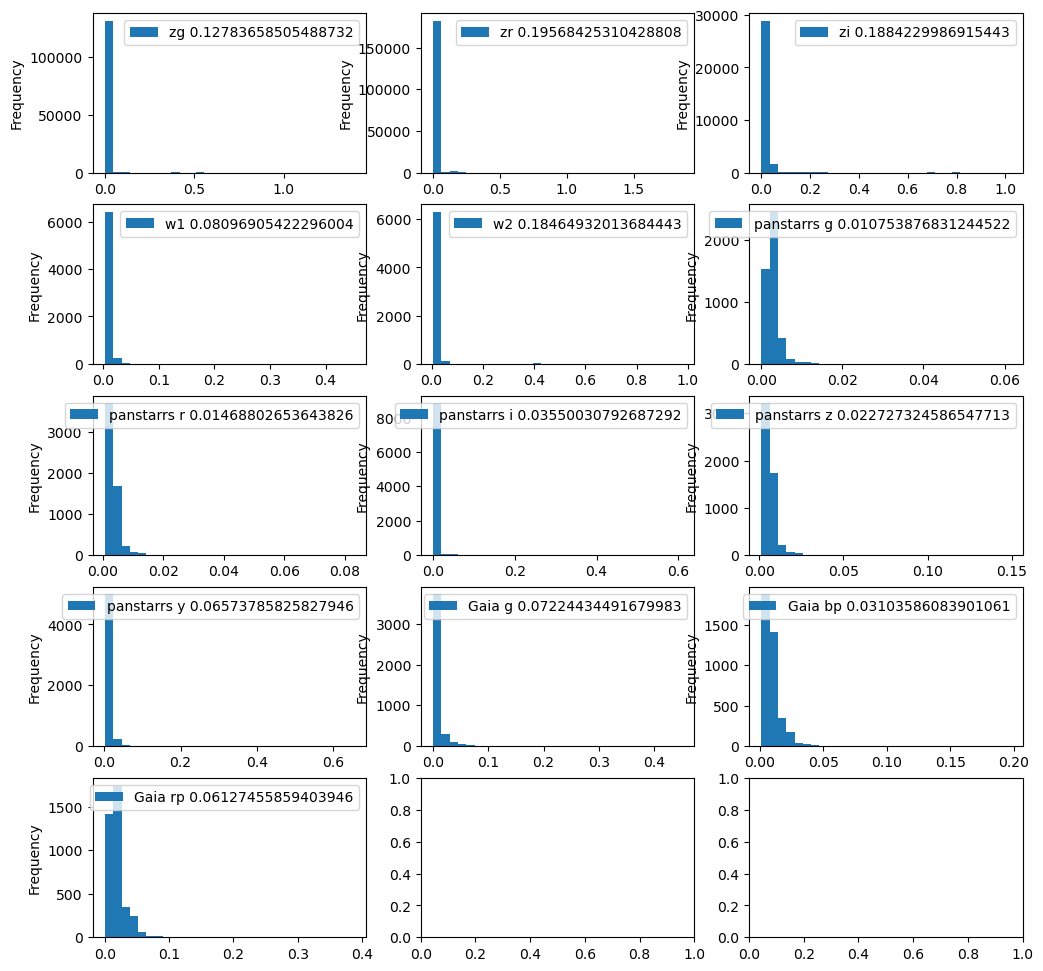

In [9]:
#consider Removing all rows with errors outside of a normal distribution
#plot histograms in flux units to see what these distributions look like

band_list = ['zg','zr','zi','w1','w2','panstarrs g','panstarrs r','panstarrs i','panstarrs z','panstarrs y','Gaia g', 'Gaia bp', 'Gaia rp']
threesigmaonmean= []

#create the figure and axes
fig, axs = plt.subplots(5, 3, figsize = (12, 12))

# unpack all the axes subplots
axe = axs.ravel()

#for each band
for count, bandname in enumerate(band_list):
    singleband = df_lc.loc[:,:,bandname,:]
    #what are the standard deviations of these distributions
    cut = singleband['err'].mean() + 3 * (singleband['err'].std())
    threesigmaonmean.append(cut)
    #plot distributions and print stddev
    singleband['err'].plot(kind = 'hist', bins = 30, subplots =True, ax = axe[count],label = bandname+' '+str(cut), legend=True)



In [10]:
#3sigma looks by eye like a reasonable cut for all distributions

#to make the cut, need to first remove the index
df_lc = df_lc.reset_index()

#create the list of which rows to cut and drop them from the dataframe
for count, bandname in enumerate(band_list):
    querystring = f'band == {bandname!r} & err > {threesigmaonmean[count]}'
    print(querystring)
    df_lc = df_lc.drop(df_lc.query(querystring).index)

#reset the index
df_lc = df_lc.set_index(["objectid", "label", "band", "time"])

band == 'zg' & err > 0.12783658505488732
band == 'zr' & err > 0.19568425310428808
band == 'zi' & err > 0.1884229986915443
band == 'w1' & err > 0.08096905422296004
band == 'w2' & err > 0.18464932013684443
band == 'panstarrs g' & err > 0.010753876831244522
band == 'panstarrs r' & err > 0.01468802653643826
band == 'panstarrs i' & err > 0.03550030792687292
band == 'panstarrs z' & err > 0.022727324586547713
band == 'panstarrs y' & err > 0.06573785825827946
band == 'Gaia g' & err > 0.07224434491679983
band == 'Gaia bp' & err > 0.03103586083901061
band == 'Gaia rp' & err > 0.06127455859403946


In [11]:
#this removed ~2% of the rows, which is reasonable and we haven't done anything drastic
df_lc


flux       err
objectid label band time                            
92       CLAGN zg   58202.309236  0.736736  0.010347
                    58202.314560  0.730595  0.010290
                    58205.302651  0.658396  0.009634
                    58205.320949  0.681111  0.009840
                    58208.357257  0.589205  0.009014
...                                    ...       ...
183      SDSS  w2   55230.410156  6.717855  0.019561
                    57054.886719  6.715584  0.023281
                    57247.308594  7.572342  0.024136
                    57977.214844  7.876407  0.023734
                    58706.855469  7.558403  0.024963

[402571 rows x 2 columns]

### 2.4 Make a new time column with datetime data type 
We need the times in python [datetime](https://docs.python.org/3/library/datetime.html) format for the next section where we will make the light curves be of uniform length. 

Once the time column is in datetime format, make it the time index

In [12]:
#need to convert df_lc time into datetime
#start by getting rid of index so that we can work with the columns
mjd = df_lc.reset_index().time

#convert to JD
jd = mjd_to_jd(mjd)

#convert to individual components
t = Time(jd, format = 'jd' )

#t.datetime is now an array of type datetime
#make it a column in the dataframe
df_lc['datetime'] = t.datetime

#remove the time index and make datetime the index
df_lc = df_lc.droplevel('time')

#set the multiindex back in place
df_lc.set_index('datetime', append = True, inplace= True)

In [13]:
df_lc

flux       err
objectid label band datetime                                      
92       CLAGN zg   2018-03-25 07:25:17.999035  0.736736  0.010347
                    2018-03-25 07:32:58.001288  0.730595  0.010290
                    2018-03-28 07:15:49.003208  0.658396  0.009634
                    2018-03-28 07:42:10.002236  0.681111  0.009840
                    2018-03-31 08:34:26.996165  0.589205  0.009014
...                                                  ...       ...
183      SDSS  w2   2010-02-03 09:50:37.500000  6.717855  0.019561
                    2015-02-01 21:16:52.500000  6.715584  0.023281
                    2015-08-13 07:24:22.500000  7.572342  0.024136
                    2017-08-12 05:09:22.500000  7.876407  0.023734
                    2019-08-11 20:31:52.500000  7.558403  0.024963

[402571 rows x 2 columns]

### 2.5  Make all objects and bands have identical time arrays (uniform length and spacing)

It is very hard to find time-domain ML algorithms which can handle non uniform length datasets. Therefore we make them uniform using Pandas [reindex](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reindex.html) which fills in the uniform length arrays with values according to the method chosen by the user.  We implement a nearest neighbor to fill the arrays.  

Fluxes with missing data are set to zero.  Zero was chosen instead of 'None' or 'Nan' as it was better integrated with the ML algorithms.  

Potential other options for uniformizing the time series dataset:
- pandas.dataframe.interpolate with many methods

In [14]:
%%time
#make a new index with the full range of datetimes and a specified frequency
final_freq = '30D'
fullindex = pd.date_range(start=df_lc.droplevel('objectid').droplevel('label').droplevel('band').index.min(), end=df_lc.droplevel('objectid').droplevel('label').droplevel('band').index.max(), freq=final_freq)

#what is the full set of unique band names?
full_bandname = df_lc.index.unique('band').tolist()

#setup to hold the resulting dataframe
df_reindex = pd.DataFrame()

#how many objects are in the dataframe?
#actually this is the max and some of them are missing
nobj = df_lc.index.unique('objectid').max() + 1

#for each objct in the dataframe
for oid in tqdm(range(nobj)):
    try:
        oid_bandname = df_lc.loc[oid,:,:,:].index.unique('band').tolist()
    except KeyError:
        #some of the data cleaning above must have removed some objects
        print(oid, ' objectid doesnt exist')
    else:
        #this is the case where the objectid exists, so let's make sure all the bands are there
        oid_label = df_lc.loc[oid,:,:,:].index.unique('label').tolist()
    
        #if bandname for this oid is not equal to the full list
        #If there are missing bands for this object
        if oid_bandname != full_bandname:
    
            #figure out which bands are missing
            missing = list(set(full_bandname).difference(oid_bandname))
        
            #make new dataframe for this object with NaN flux and err values
            #choosing random times for now that will get fleshed out when I reindex all times below
            for m in range(len(missing)):
                datetimelist = [pd.to_datetime(1490195805, unit='s'), pd.to_datetime(1491195805, unit='s')]  #making this up for now
                dfsingle = pd.DataFrame(dict(flux=np.zeros(2), err=np.zeros(2), datetime=datetimelist, objectid=oid, band=missing[m],label=oid_label[0])).set_index(["objectid","label", "band", "datetime"])        

                #now concatenate the single new df with df_lc
                df_lc = pd.concat([df_lc, dfsingle])
            
        #for each band
        for bandid in range(len(full_bandname)):
    
            #set up to only have time as an index
            single_obj = df_lc.loc[oid,:,full_bandname[bandid],:].reset_index().set_index('datetime')
    
            #sort the time index
            single_obj = single_obj.sort_index()
    
            #change the time index to have values in fullindex, and use 'nearest' to fill
            #in values of the new time indices
            #this is where the real work gets done
            single_reindex = single_obj.reindex(fullindex, method = 'nearest')
    
            #previous command returns an unnamed index, so name it
            single_reindex.index.rename('datetime', inplace= True)
    
            #then we really want a multiindex df, so first remove indices, then set the ones we want
            single_reindex.reset_index(inplace= True)
            
            #put oid and bandname back into the dataframe
            single_reindex['objectid'] = oid
            single_reindex['band'] = full_bandname[bandid]
            
            #re-make index
            single_reindex.set_index(["objectid" ,"label","band", "datetime"], inplace = True)
    
            #concatenate all the dfs together
            if df_reindex.empty: 
                df_reindex = single_reindex
            else:
                df_reindex = pd.concat([df_reindex, single_reindex])

 10%|█         | 47/458 [00:18<02:54,  2.36it/s]

47  objectid doesnt exist


 18%|█▊        | 81/458 [00:45<03:53,  1.62it/s]

81  objectid doesnt exist


 24%|██▎       | 108/458 [01:08<05:03,  1.15it/s]

108  objectid doesnt exist


 24%|██▍       | 112/458 [01:12<05:26,  1.06it/s]

112  objectid doesnt exist
113  objectid doesnt exist
114  objectid doesnt exist


 55%|█████▌    | 252/458 [04:48<07:07,  2.08s/it]

252  objectid doesnt exist


100%|██████████| 458/458 [13:43<00:00,  1.80s/it]

CPU times: user 12min 20s, sys: 1min 23s, total: 13min 43s
Wall time: 13min 43s


In [15]:
df_reindex

flux       err
objectid label band datetime                                      
0        CLAGN zg   2009-06-03 06:37:08.765742  0.033659  0.004089
                    2009-07-03 06:37:08.765742  0.033659  0.004089
                    2009-08-02 06:37:08.765742  0.033659  0.004089
                    2009-09-01 06:37:08.765742  0.033659  0.004089
                    2009-10-01 06:37:08.765742  0.033659  0.004089
...                                                  ...       ...
457      SDSS  w2   2022-10-23 06:37:08.765742  1.435361  0.017771
                    2022-11-22 06:37:08.765742  1.435361  0.017771
                    2022-12-22 06:37:08.765742  1.435361  0.017771
                    2023-01-21 06:37:08.765742  1.435361  0.017771
                    2023-02-20 06:37:08.765742  1.435361  0.017771

[984984 rows x 2 columns]

In [16]:
#proove this did what I wanted it to do
oid = 0
#how many bandnames in object 0?
bn = df_lc.loc[oid,:,:,:].index.unique('band').tolist()
print('there are', bn, 'bandnames ')
#how many times per band in object 0
oid_bandname = df_reindex.loc[oid,:,:,:].index.unique('band').tolist()
for i in range(len(oid_bandname) ):
    times = df_reindex.loc[oid,:,oid_bandname[i],:].index.unique('datetime').tolist()
    print('for band', oid_bandname[i],' there are ', len(times),' times')
    
    
#output from this cell should show that all bands have the same length

there are ['zg', 'zr', 'zi', 'panstarrs i', 'panstarrs y', 'panstarrs z', 'panstarrs g', 'panstarrs r', 'Gaia g', 'Gaia bp', 'Gaia rp', 'w1', 'w2'] bandnames 
for band zg  there are  168  times
for band zr  there are  168  times
for band zi  there are  168  times
for band panstarrs i  there are  168  times
for band panstarrs y  there are  168  times
for band panstarrs z  there are  168  times
for band panstarrs g  there are  168  times
for band panstarrs r  there are  168  times
for band Gaia g  there are  168  times
for band Gaia bp  there are  168  times
for band Gaia rp  there are  168  times
for band w1  there are  168  times
for band w2  there are  168  times


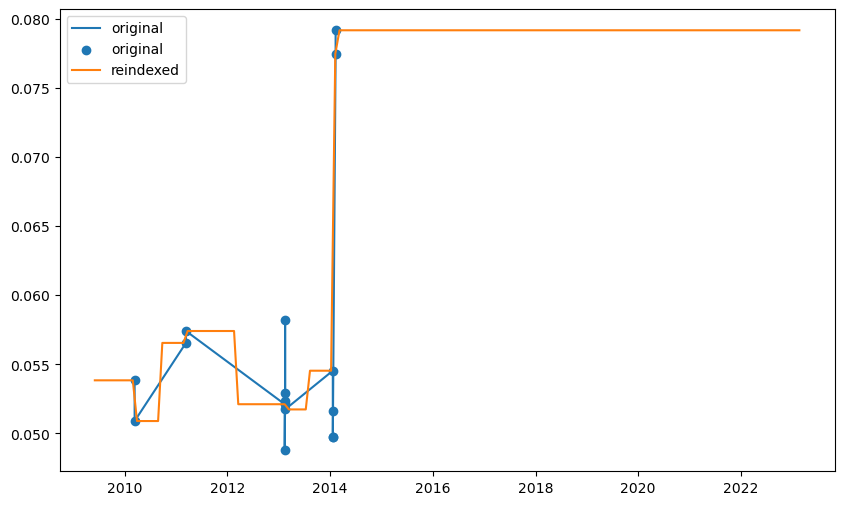

In [17]:
#figure out if this 'nearest' reindexing is a reasonable choice for this use case
#plotting the light curves before and after reindexing.

#pick one object, one band for now
dfsingle_before = df_lc.loc[4,:,'panstarrs r',:]
dfsingle_after = df_reindex.loc[4,:,'panstarrs r',:]

#time in a format matplotlib can handle
t1 = dfsingle_before.index.get_level_values('datetime').to_pydatetime()
f1 = dfsingle_before.flux

fig, ax = plt.subplots(figsize=(10,6))
f = ax.plot(t1, f1, label = "original") 
f = ax.scatter(t1, f1, label = "original")

t2 = dfsingle_after.index.get_level_values('datetime').to_pydatetime()
f2 = dfsingle_after.flux
f = ax.plot(t2, f2, label = "reindexed") 
ax.legend()



### 2.6 Normalize to the mean of each objectid
- this is normalizing across all bands
- think this is the right place to do this, rather than before we reindex over time 
    so that the final light curves are normalized since that is the chunk of information 
    which goes into the ML algorithms.
- chose mean and not median because there are some objects where the median flux = 0.0
    - if we did this before the reindexing, the median might be a non-zero value
- normalizing is required so that the CLAGN and it's comparison SDSS sample don't have different flux levels.

In [18]:
#what does the dataframe currently look like
df_reindex

flux       err
objectid label band datetime                                      
0        CLAGN zg   2009-06-03 06:37:08.765742  0.033659  0.004089
                    2009-07-03 06:37:08.765742  0.033659  0.004089
                    2009-08-02 06:37:08.765742  0.033659  0.004089
                    2009-09-01 06:37:08.765742  0.033659  0.004089
                    2009-10-01 06:37:08.765742  0.033659  0.004089
...                                                  ...       ...
457      SDSS  w2   2022-10-23 06:37:08.765742  1.435361  0.017771
                    2022-11-22 06:37:08.765742  1.435361  0.017771
                    2022-12-22 06:37:08.765742  1.435361  0.017771
                    2023-01-21 06:37:08.765742  1.435361  0.017771
                    2023-02-20 06:37:08.765742  1.435361  0.017771

[984984 rows x 2 columns]

In [19]:
#idea here is that we normalize across each object.  
#so the code will know for example that within one object W1 will be brighter than ZTF bands
#but from one object to the next, it will not know that one is brighter than the other.

In [20]:
#try standardizing each object separately
#same idea that we are trying to remove the signal that some objects are brighter than others
#but keep the info about relative differences within each object.

#setup new column to hold the normalized fluxes
df_reindex[["normflux"]] = 100

#can't figure out how to do this when using multiindex, so get rid of it for a minute
#remove the index
df_reindex_reset = df_reindex.reset_index()


#how many objects are in the dataframe?
#actually this is the max and some of them are missing
nobj = df_reindex.index.unique('objectid').max() + 1

#for each objct in the dataframe
for oid in tqdm(range(nobj)):
    try:
        #what is the median flux of all bands for this object?
        meanflux = df_reindex.loc[oid,:,:,:].flux.mean(skipna = True)
        stdflux = df_reindex.loc[oid,:,:,:].flux.std(skipna=True)
        print('mean flux', meanflux)
    except KeyError:
        #some of the data cleaning above must have removed some objects
        print(oid, ' objectid doesnt exist')
    else:
        querystring = f'objectid == {oid}'
        zflux = (df_reindex_reset.query(querystring).flux.values - meanflux) / stdflux
        datetime = df_reindex_reset.query(querystring).datetime.values
        objectid = df_reindex_reset.query(querystring).objectid.values
        band = df_reindex_reset.query(querystring).band.values
        label = df_reindex_reset.query(querystring).label.values
        dfsingle = pd.DataFrame(dict(flux=zflux, err=df_reindex.loc[oid,:,:,:].err, datetime=datetime, objectid=objectid, band=band,label=label))

        #now concatenate the single new df with df_lc
        if oid == 0:
            df_norm = dfsingle
        else:
            df_norm = pd.concat([df_norm, dfsingle])
            
            
#reset the index
df_norm = df_norm.set_index(["objectid", "label", "band", "datetime"])

  0%|          | 1/458 [00:00<00:48,  9.34it/s]

mean flux 0.10957195241465305
mean flux 0.21076464634627848
mean flux 0.07253310177916786


  1%|          | 5/458 [00:00<00:28, 15.73it/s]

mean flux 0.03932266878132568
mean flux 0.1560503757407331
mean flux 0.27927292174861806
mean flux 0.27828456500993454


  2%|▏         | 9/458 [00:00<00:27, 16.18it/s]

mean flux 0.08084706004343126
mean flux 0.08296278297111931
mean flux 0.1235951483408649
mean flux 0.15332101642792148


  3%|▎         | 13/458 [00:00<00:27, 16.06it/s]

mean flux 0.07357874824219639
mean flux 0.18405317342463415
mean flux 0.061727430229934294
mean flux 0.12642644181104684


  4%|▎         | 17/458 [00:01<00:27, 15.79it/s]

mean flux 0.21275635972071344
mean flux 0.22172854244830137
mean flux 0.1683987244028109
mean flux 0.15777563080978066


  5%|▍         | 21/458 [00:01<00:27, 15.74it/s]

mean flux 0.3502430121685114
mean flux 0.20666290930495906
mean flux 0.10647337412808432
mean flux 0.1286837478894534


  5%|▌         | 25/458 [00:01<00:28, 15.43it/s]

mean flux 0.28633341731274853
mean flux 0.0902175284995533
mean flux 0.1394178545072603
mean flux 0.28611932555230757


  6%|▋         | 29/458 [00:01<00:28, 15.15it/s]

mean flux 0.0729216239442719
mean flux 0.31705936255441103
mean flux 0.19835805228233883
mean flux 0.3307963026347012


  7%|▋         | 33/458 [00:02<00:28, 14.92it/s]

mean flux 0.10957894583835794
mean flux 0.24365096446018983
mean flux 0.4479311414696196


  8%|▊         | 35/458 [00:02<00:28, 14.75it/s]

mean flux 0.1303804079389588
mean flux 0.04966695816262015
mean flux 0.13617856240652787


  9%|▊         | 39/458 [00:02<00:29, 14.41it/s]

mean flux 0.19428441705632118
mean flux 0.20380295739950238
mean flux 0.035728945524001826


  9%|▉         | 41/458 [00:02<00:29, 14.19it/s]

mean flux 1.3391373636650084
mean flux 0.17746702838799386
mean flux 0.04386213753055483


 10%|▉         | 45/458 [00:03<00:29, 13.90it/s]

mean flux 0.20804124544608474
mean flux 0.8426958584430232
mean flux 0.19320985885575423


 10%|█         | 47/458 [00:03<00:29, 13.73it/s]

mean flux 0.14688133553751495
47  objectid doesnt exist
mean flux 16.453114352698563
mean flux 4.298290122322834


 11%|█▏        | 52/458 [00:03<00:27, 15.03it/s]

mean flux 5.3007989360864745
mean flux 7.0015531581836745
mean flux 1.2265971198108112


 12%|█▏        | 54/458 [00:03<00:28, 14.40it/s]

mean flux 5.766508689834643
mean flux 1.8084407207672006
mean flux 0.7330693913225308


 13%|█▎        | 58/458 [00:03<00:29, 13.59it/s]

mean flux 9.90575594168443
mean flux 4.008698936635882
mean flux 3.2123544900927734


 13%|█▎        | 60/458 [00:04<00:29, 13.27it/s]

mean flux 6.631940043210409
mean flux 27.54771411398937
mean flux 6.4604138471538075


 14%|█▍        | 64/458 [00:04<00:30, 12.92it/s]

mean flux 9.943742389585406
mean flux 0.8306167819524182
mean flux 0.9443509290848819


 14%|█▍        | 66/458 [00:04<00:30, 12.73it/s]

mean flux 0.2751985350305347
mean flux 1.5298739009018762
mean flux 7.039023739991835


 15%|█▌        | 70/458 [00:04<00:31, 12.43it/s]

mean flux 0.7136752799851699
mean flux 0.5596604289545618
mean flux 0.4785017393376591


 16%|█▌        | 72/458 [00:05<00:31, 12.24it/s]

mean flux 2.0503173461208832
mean flux 2.690428881405593
mean flux 1.2860600600510583


 17%|█▋        | 76/458 [00:05<00:31, 12.00it/s]

mean flux 9.552080112527577
mean flux 0.4762530588076413
mean flux 0.3306243807250809


 17%|█▋        | 78/458 [00:05<00:32, 11.79it/s]

mean flux 20.730212441979376
mean flux 0.3601286630470228
mean flux 0.4776091316589126


 18%|█▊        | 83/458 [00:05<00:28, 13.36it/s]

mean flux 1.6861678904259858
81  objectid doesnt exist
mean flux 4.062949491433799
mean flux 23.37967435709532


 19%|█▊        | 85/458 [00:06<00:29, 12.70it/s]

mean flux 0.33544971063361556
mean flux 1.0703538472835834
mean flux 11.09442718937117


 19%|█▉        | 89/458 [00:06<00:30, 11.95it/s]

mean flux 1.4219378358400714
mean flux 0.5606105264090414
mean flux 20.019504818287526


 20%|█▉        | 91/458 [00:06<00:31, 11.62it/s]

mean flux 0.8781920897550509
mean flux 6.758468371788358
mean flux 1.8772358724310247


 21%|██        | 95/458 [00:07<00:32, 11.09it/s]

mean flux 0.39481108197701165
mean flux 0.1614034219410989
mean flux 21.60130707952171


 21%|██        | 97/458 [00:07<00:33, 10.91it/s]

mean flux 0.6675729730248018
mean flux 1.383748622933997
mean flux 1.243630550524653


 22%|██▏       | 101/458 [00:07<00:33, 10.65it/s]

mean flux 0.5821012383106017
mean flux 0.30689886416629414
mean flux 0.2760069965254803


 22%|██▏       | 103/458 [00:07<00:33, 10.53it/s]

mean flux 1.0121223335906897
mean flux 0.7672915492030198
mean flux 10.579780271310947


 23%|██▎       | 107/458 [00:08<00:34, 10.28it/s]

mean flux 0.41475291822779264
mean flux 9.724952311818189
mean flux 11.60326583212075


 24%|██▍       | 111/458 [00:08<00:29, 11.62it/s]

108  objectid doesnt exist
mean flux 17.949427632743657
mean flux 2.0163699011881273
mean flux 13.633737836402915


 25%|██▌       | 116/458 [00:08<00:21, 15.99it/s]

112  objectid doesnt exist
113  objectid doesnt exist
114  objectid doesnt exist
mean flux 0.003563324122556618
mean flux 1.8654847609568608


 26%|██▌       | 118/458 [00:08<00:24, 13.85it/s]

mean flux 0.7940292485961813
mean flux 0.9635140863495409


 26%|██▌       | 120/458 [00:09<00:26, 12.56it/s]

mean flux 0.6492912644543798
mean flux 1.1203635623507806


 27%|██▋       | 122/458 [00:09<00:28, 11.62it/s]

mean flux 5.654923040423281
mean flux 1.1729506874428448


 27%|██▋       | 124/458 [00:09<00:30, 10.99it/s]

mean flux 1.4318351552445938
mean flux 0.6960466478940687


 28%|██▊       | 126/458 [00:09<00:31, 10.53it/s]

mean flux 2.781654918392976
mean flux 0.8497965510511573


 28%|██▊       | 128/458 [00:09<00:32, 10.18it/s]

mean flux 3.5803101120321856
mean flux 2.220219261481224


 28%|██▊       | 130/458 [00:10<00:32,  9.97it/s]

mean flux 0.8898051540364652
mean flux 2.0765485639784407


 29%|██▉       | 132/458 [00:10<00:33,  9.81it/s]

mean flux 0.8885318225338346
mean flux 2.1161231082001013


 29%|██▉       | 134/458 [00:10<00:33,  9.64it/s]

mean flux 6.39324001162355
mean flux 0.5395114519820982


 30%|██▉       | 136/458 [00:10<00:33,  9.47it/s]

mean flux 0.9826264290800898
mean flux 1.293653708019536


 30%|███       | 138/458 [00:11<00:34,  9.30it/s]

mean flux 0.6752316008040178
mean flux 0.9337747786944602


 31%|███       | 140/458 [00:11<00:34,  9.20it/s]

mean flux 2.175039536599026
mean flux 0.7918135266164283


 31%|███       | 142/458 [00:11<00:35,  8.86it/s]

mean flux 1.5867371020828847
mean flux 0.7511615165860661


 31%|███▏      | 144/458 [00:11<00:35,  8.86it/s]

mean flux 5.129661931926283
mean flux 0.09356127438098201


 32%|███▏      | 146/458 [00:11<00:36,  8.61it/s]

mean flux 0.04026140470623483
mean flux 0.26500645675947504


 32%|███▏      | 148/458 [00:12<00:36,  8.43it/s]

mean flux 0.14741253228060305
mean flux 0.23602740581208342


 33%|███▎      | 150/458 [00:12<00:36,  8.52it/s]

mean flux 0.30302291754116606
mean flux 0.042312985441133696


 33%|███▎      | 152/458 [00:12<00:34,  8.84it/s]

mean flux 0.1462509287352378
mean flux 0.09022585578496534


 34%|███▎      | 154/458 [00:12<00:35,  8.60it/s]

mean flux 0.09050530616398211
mean flux 0.21050014868426467


 34%|███▍      | 156/458 [00:13<00:36,  8.37it/s]

mean flux 0.058498673866558104
mean flux 0.07716436524567802


 34%|███▍      | 158/458 [00:13<00:35,  8.36it/s]

mean flux 0.182617280748848
mean flux 0.21844762215895666


 35%|███▍      | 160/458 [00:13<00:35,  8.51it/s]

mean flux 0.16209288621368267
mean flux 0.13225322424543717


 35%|███▌      | 162/458 [00:13<00:34,  8.62it/s]

mean flux 0.27426525340738195
mean flux 0.27325781369360524


 36%|███▌      | 164/458 [00:14<00:33,  8.68it/s]

mean flux 0.1079192685794992
mean flux 0.07304683177500461


 36%|███▌      | 166/458 [00:14<00:34,  8.47it/s]

mean flux 0.03267155284891284
mean flux 0.004219636282322734


 37%|███▋      | 168/458 [00:14<00:34,  8.36it/s]

mean flux 0.004307591016119233
mean flux 0.007999042721792598


 37%|███▋      | 170/458 [00:14<00:33,  8.51it/s]

mean flux 0.04611121542753448
mean flux 0.015512963718546971


 38%|███▊      | 172/458 [00:14<00:33,  8.50it/s]

mean flux 0.04302514141439435
mean flux 0.006615989387113916


 38%|███▊      | 174/458 [00:15<00:37,  7.66it/s]

mean flux 0.01915150002525004
mean flux 0.030414261089029743


 38%|███▊      | 176/458 [00:15<00:37,  7.62it/s]

mean flux 0.055098559802283925
mean flux 3.816159155030667


 39%|███▉      | 178/458 [00:15<00:36,  7.58it/s]

mean flux 0.050163836182371246
mean flux 0.015044558324083218


 39%|███▉      | 180/458 [00:16<00:36,  7.58it/s]

mean flux 0.0489789208388988
mean flux 0.024607538139516844


 40%|███▉      | 182/458 [00:16<00:36,  7.62it/s]

mean flux 1.5994103670430808
mean flux 0.23022515800228957


 40%|████      | 184/458 [00:16<00:36,  7.58it/s]

mean flux 2.8895467932881918
mean flux 2.8524841498097375


 41%|████      | 186/458 [00:16<00:35,  7.58it/s]

mean flux 0.773535146464225
mean flux 0.07292865113798969


 41%|████      | 188/458 [00:17<00:35,  7.56it/s]

mean flux 0.8143083466495187
mean flux 0.007705403531275222


 41%|████▏     | 190/458 [00:17<00:35,  7.48it/s]

mean flux 0.010312650721872955
mean flux 0.22564500181831268


 42%|████▏     | 192/458 [00:17<00:36,  7.31it/s]

mean flux 1.4718565574747162
mean flux 0.0022530007596033522


 42%|████▏     | 194/458 [00:17<00:36,  7.27it/s]

mean flux 0.05758618730831395
mean flux 0.011063136020481435


 43%|████▎     | 196/458 [00:18<00:36,  7.27it/s]

mean flux 0.49752491445749203
mean flux 0.03315175804793354


 43%|████▎     | 198/458 [00:18<00:35,  7.32it/s]

mean flux 1.7733882589593661
mean flux 1.9667395022708898


 44%|████▎     | 200/458 [00:18<00:35,  7.24it/s]

mean flux 1.8682725134221425
mean flux 1.7342427582046591


 44%|████▍     | 202/458 [00:19<00:36,  7.08it/s]

mean flux 0.004415141070253096
mean flux 0.08291311254185511


 45%|████▍     | 204/458 [00:19<00:36,  7.00it/s]

mean flux 3.20335060394799
mean flux 1.5459792256250822


 45%|████▍     | 206/458 [00:19<00:37,  6.81it/s]

mean flux 0.8792014711859888
mean flux 1.454227632320843


 45%|████▌     | 208/458 [00:19<00:36,  6.94it/s]

mean flux 0.024189070388932258
mean flux 0.014754036739246565


 46%|████▌     | 210/458 [00:20<00:36,  6.80it/s]

mean flux 4.238120445096458
mean flux 1.119532316784434


 46%|████▋     | 212/458 [00:20<00:36,  6.76it/s]

mean flux 0.11900021359597371
mean flux 0.08638118192449898


 47%|████▋     | 214/458 [00:20<00:36,  6.76it/s]

mean flux 7.988097211077138
mean flux 0.01266904877382677


 47%|████▋     | 216/458 [00:21<00:36,  6.63it/s]

mean flux 0.013839345218939075
mean flux 1.953340432943711


 48%|████▊     | 218/458 [00:21<00:36,  6.63it/s]

mean flux 0.0602934203849242
mean flux 0.03846453783007565


 48%|████▊     | 220/458 [00:21<00:35,  6.74it/s]

mean flux 1.8905116127428858
mean flux 1.3558373552359517


 48%|████▊     | 222/458 [00:22<00:34,  6.77it/s]

mean flux 2.5416442885708403
mean flux 1.6229871706867622


 49%|████▉     | 224/458 [00:22<00:34,  6.84it/s]

mean flux 0.5506797174616547
mean flux 0.03922160324376985


 49%|████▉     | 226/458 [00:22<00:33,  6.83it/s]

mean flux 2.5640638278680017
mean flux 1.9899756636134165


 50%|████▉     | 228/458 [00:22<00:34,  6.74it/s]

mean flux 4.11554876367621
mean flux 6.274221523726958


 50%|█████     | 230/458 [00:23<00:34,  6.70it/s]

mean flux 1.5615600744127915
mean flux 0.730924498198915


 51%|█████     | 232/458 [00:23<00:33,  6.68it/s]

mean flux 1.4183403225956903
mean flux 1.5418576892744604


 51%|█████     | 234/458 [00:23<00:33,  6.66it/s]

mean flux 0.764673977764237
mean flux 1.184226534571615


 52%|█████▏    | 236/458 [00:24<00:33,  6.55it/s]

mean flux 1.332095569677075
mean flux 0.02709465188245503


 52%|█████▏    | 238/458 [00:24<00:33,  6.61it/s]

mean flux 0.6457891315407569
mean flux 0.9712179403789023


 52%|█████▏    | 240/458 [00:24<00:32,  6.65it/s]

mean flux 0.2533276949982995
mean flux 6.514705404757385


 53%|█████▎    | 242/458 [00:25<00:32,  6.59it/s]

mean flux 1.800831508076116
mean flux 1.0458105185858695


 53%|█████▎    | 244/458 [00:25<00:32,  6.61it/s]

mean flux 7.221956192359499
mean flux 1.065843245244632


 54%|█████▎    | 246/458 [00:25<00:33,  6.32it/s]

mean flux 0.3452685479913578
mean flux 1.541639210353355


 54%|█████▍    | 248/458 [00:25<00:33,  6.24it/s]

mean flux 2.8588504898413625
mean flux 1.654314916941339


 55%|█████▍    | 250/458 [00:26<00:33,  6.25it/s]

mean flux 0.9717360745564859
mean flux 0.007717831775773082


 55%|█████▌    | 252/458 [00:26<00:33,  6.09it/s]

mean flux 1.194337665509472
252  objectid doesnt exist
mean flux 0.02929038527728283


 56%|█████▌    | 255/458 [00:26<00:27,  7.27it/s]

mean flux 1.6370633149740765
mean flux 0.945081411296578


 56%|█████▌    | 257/458 [00:27<00:30,  6.51it/s]

mean flux 1.8015124140317018
mean flux 1.0719611362974506


 57%|█████▋    | 259/458 [00:27<00:32,  6.20it/s]

mean flux 3.0831458623682253
mean flux 0.5246119756585302


 57%|█████▋    | 261/458 [00:27<00:32,  6.03it/s]

mean flux 0.6323777687890281
mean flux 1.403546389958093


 57%|█████▋    | 263/458 [00:28<00:33,  5.90it/s]

mean flux 2.288903323812104
mean flux 0.00801383660013218


 58%|█████▊    | 265/458 [00:28<00:34,  5.58it/s]

mean flux 5.314861188175814
mean flux 1.4033558941270103


 58%|█████▊    | 267/458 [00:29<00:34,  5.61it/s]

mean flux 3.6661885205296363
mean flux 1.0202046107439715


 59%|█████▊    | 269/458 [00:29<00:33,  5.64it/s]

mean flux 1.6602011010226012
mean flux 1.0111037907700278


 59%|█████▉    | 271/458 [00:29<00:32,  5.67it/s]

mean flux 1.0647511060061594
mean flux 1.0737968127451905


 60%|█████▉    | 273/458 [00:30<00:32,  5.73it/s]

mean flux 0.7035359434157957
mean flux 1.9615158306825575


 60%|██████    | 275/458 [00:30<00:32,  5.57it/s]

mean flux 2.228693151525774
mean flux 0.14456073897851204


 60%|██████    | 277/458 [00:30<00:33,  5.39it/s]

mean flux 1.0282581329812084
mean flux 1.2422264661836493


 61%|██████    | 279/458 [00:31<00:33,  5.36it/s]

mean flux 0.649968209673349
mean flux 3.5647593748809805


 61%|██████▏   | 281/458 [00:31<00:32,  5.43it/s]

mean flux 1.2632458132907645
mean flux 1.5683433221610201


 62%|██████▏   | 283/458 [00:32<00:32,  5.37it/s]

mean flux 3.070222999858897
mean flux 0.4491787652784639


 62%|██████▏   | 285/458 [00:32<00:32,  5.40it/s]

mean flux 4.812428994731229
mean flux 1.0780184754500814


 63%|██████▎   | 287/458 [00:32<00:31,  5.43it/s]

mean flux 1.4230679822423273
mean flux 0.2664778537215274


 63%|██████▎   | 289/458 [00:33<00:30,  5.49it/s]

mean flux 0.8620749793777253
mean flux 0.8729118840265834


 64%|██████▎   | 291/458 [00:33<00:30,  5.45it/s]

mean flux 1.323431634485191
mean flux 0.8982248251206876


 64%|██████▍   | 293/458 [00:33<00:30,  5.33it/s]

mean flux 0.9159600437306322
mean flux 2.3430252695246505


 64%|██████▍   | 295/458 [00:34<00:30,  5.30it/s]

mean flux 2.7306838361024575
mean flux 0.014631476404642435


 65%|██████▍   | 297/458 [00:34<00:30,  5.24it/s]

mean flux 1.8807654205128264
mean flux 0.4933236378793826


 65%|██████▌   | 299/458 [00:34<00:29,  5.45it/s]

mean flux 0.743447013829046
mean flux 2.1465203303813998


 66%|██████▌   | 301/458 [00:35<00:28,  5.52it/s]

mean flux 1.3399408548721972
mean flux 0.049303300193272385


 66%|██████▌   | 303/458 [00:35<00:27,  5.56it/s]

mean flux 1.966034549118028
mean flux 2.300719866827374


 67%|██████▋   | 305/458 [00:36<00:27,  5.47it/s]

mean flux 2.208950039696757
mean flux 1.4197204371613275


 67%|██████▋   | 307/458 [00:36<00:27,  5.54it/s]

mean flux 0.3359323737277064
mean flux 1.8879786773672558


 67%|██████▋   | 309/458 [00:36<00:26,  5.57it/s]

mean flux 0.2909957886647503
mean flux 3.826843450916239


 68%|██████▊   | 311/458 [00:37<00:27,  5.25it/s]

mean flux 0.6871554868944171
mean flux 2.0776866046425404


 68%|██████▊   | 313/458 [00:37<00:28,  5.10it/s]

mean flux 1.0328417835728336
mean flux 0.8043429628293038


 69%|██████▉   | 315/458 [00:37<00:28,  5.08it/s]

mean flux 0.008005812223014318
mean flux 3.0464716976945736


 69%|██████▉   | 317/458 [00:38<00:27,  5.10it/s]

mean flux 1.5479611771671984
mean flux 0.02294922391431076


 70%|██████▉   | 319/458 [00:38<00:27,  5.03it/s]

mean flux 1.272082308535161
mean flux 0.3957671008596922


 70%|██████▉   | 320/458 [00:38<00:28,  4.90it/s]

mean flux 0.5813295646612695


 70%|███████   | 322/458 [00:39<00:27,  4.88it/s]

mean flux 0.6745189960160584
mean flux 0.607774020600574


 71%|███████   | 324/458 [00:39<00:27,  4.87it/s]

mean flux 3.339435572893625
mean flux 1.3661553230891945


 71%|███████   | 325/458 [00:40<00:26,  4.94it/s]

mean flux 0.307175220196087


 71%|███████▏  | 327/458 [00:40<00:27,  4.79it/s]

mean flux 2.0987167100088824
mean flux 1.1364150933978088


 72%|███████▏  | 328/458 [00:40<00:28,  4.61it/s]

mean flux 1.3459805234884359


 72%|███████▏  | 330/458 [00:41<00:27,  4.68it/s]

mean flux 0.449515837802843
mean flux 2.1858152103442268


 72%|███████▏  | 331/458 [00:41<00:26,  4.72it/s]

mean flux 1.1945869487396878


 73%|███████▎  | 333/458 [00:41<00:26,  4.72it/s]

mean flux 1.543548460482272
mean flux 2.113611275852772


 73%|███████▎  | 335/458 [00:42<00:27,  4.51it/s]

mean flux 0.6628458995304931
mean flux 1.7767328947488688


 73%|███████▎  | 336/458 [00:42<00:27,  4.42it/s]

mean flux 0.8319863279361704


 74%|███████▍  | 338/458 [00:42<00:26,  4.55it/s]

mean flux 3.106385290420532
mean flux 0.9977787719335263


 74%|███████▍  | 340/458 [00:43<00:25,  4.56it/s]

mean flux 0.01175855209954874
mean flux 0.4895015834226798


 74%|███████▍  | 341/458 [00:43<00:26,  4.42it/s]

mean flux 0.6107711308481205


 75%|███████▍  | 343/458 [00:43<00:25,  4.57it/s]

mean flux 0.40141919258033776
mean flux 0.8763425136776852


 75%|███████▌  | 345/458 [00:44<00:24,  4.61it/s]

mean flux 5.696340219974932
mean flux 0.01113957487081977


 76%|███████▌  | 346/458 [00:44<00:24,  4.49it/s]

mean flux 3.898480956121011


 76%|███████▌  | 348/458 [00:45<00:23,  4.61it/s]

mean flux 0.8044766668076869
mean flux 0.8605320288227619


 76%|███████▌  | 349/458 [00:45<00:24,  4.48it/s]

mean flux 0.7746049876515544


 76%|███████▋  | 350/458 [00:45<00:23,  4.56it/s]

mean flux 1.0678367264956858


 77%|███████▋  | 351/458 [00:45<00:24,  4.41it/s]

mean flux 1.326878740042052


 77%|███████▋  | 352/458 [00:45<00:23,  4.50it/s]

mean flux 3.020921392409813


 77%|███████▋  | 353/458 [00:46<00:24,  4.33it/s]

mean flux 1.4061781221611311


 78%|███████▊  | 355/458 [00:46<00:22,  4.51it/s]

mean flux 0.24756665571730566
mean flux 0.9072818055438546


 78%|███████▊  | 356/458 [00:46<00:23,  4.36it/s]

mean flux 2.948693290540416


 78%|███████▊  | 357/458 [00:47<00:22,  4.46it/s]

mean flux 0.015875230497819713


 78%|███████▊  | 358/458 [00:47<00:22,  4.36it/s]

mean flux 1.095780123507976


 78%|███████▊  | 359/458 [00:47<00:22,  4.31it/s]

mean flux 1.132588328885198


 79%|███████▊  | 360/458 [00:47<00:22,  4.43it/s]

mean flux 0.05226578392400654


 79%|███████▉  | 361/458 [00:48<00:22,  4.33it/s]

mean flux 0.03295368180339485


 79%|███████▉  | 362/458 [00:48<00:22,  4.32it/s]

mean flux 1.2055699474689257


 79%|███████▉  | 363/458 [00:48<00:22,  4.25it/s]

mean flux 1.0794463068806575


 79%|███████▉  | 364/458 [00:48<00:22,  4.26it/s]

mean flux 0.3317168134993935


 80%|███████▉  | 365/458 [00:48<00:21,  4.40it/s]

mean flux 1.7398080658337052


 80%|███████▉  | 366/458 [00:49<00:21,  4.28it/s]

mean flux 1.3122247566733762


 80%|████████  | 367/458 [00:49<00:20,  4.37it/s]

mean flux 0.5000449735617027


 80%|████████  | 368/458 [00:49<00:20,  4.29it/s]

mean flux 1.501947899542886


 81%|████████  | 369/458 [00:49<00:20,  4.42it/s]

mean flux 2.2798341249759178


 81%|████████  | 370/458 [00:50<00:20,  4.29it/s]

mean flux 2.143406154348076


 81%|████████  | 371/458 [00:50<00:20,  4.32it/s]

mean flux 0.6331594349325097


 81%|████████  | 372/458 [00:50<00:19,  4.34it/s]

mean flux 0.4948158903381136


 81%|████████▏ | 373/458 [00:50<00:20,  4.20it/s]

mean flux 0.4434057596657199


 82%|████████▏ | 374/458 [00:51<00:20,  4.20it/s]

mean flux 1.6464877037823618


 82%|████████▏ | 375/458 [00:51<00:20,  4.13it/s]

mean flux 0.6833130610177427


 82%|████████▏ | 376/458 [00:51<00:19,  4.14it/s]

mean flux 0.9201705758108328


 82%|████████▏ | 377/458 [00:51<00:19,  4.11it/s]

mean flux 1.236818800605917


 83%|████████▎ | 378/458 [00:52<00:19,  4.15it/s]

mean flux 2.1466661172540364


 83%|████████▎ | 379/458 [00:52<00:19,  4.14it/s]

mean flux 4.59383303514436


 83%|████████▎ | 380/458 [00:52<00:18,  4.17it/s]

mean flux 0.6089970983144842


 83%|████████▎ | 381/458 [00:52<00:18,  4.12it/s]

mean flux 1.486135563011425


 83%|████████▎ | 382/458 [00:53<00:19,  3.95it/s]

mean flux 1.0905259484706107


 84%|████████▎ | 383/458 [00:53<00:19,  3.94it/s]

mean flux 1.4989964007662684


 84%|████████▍ | 384/458 [00:53<00:18,  3.97it/s]

mean flux 1.2923826126626579


 84%|████████▍ | 385/458 [00:53<00:18,  3.92it/s]

mean flux 1.1574331053828588


 84%|████████▍ | 386/458 [00:54<00:18,  3.89it/s]

mean flux 0.66383401974453


 84%|████████▍ | 387/458 [00:54<00:17,  3.96it/s]

mean flux 0.9765930172377745


 85%|████████▍ | 388/458 [00:54<00:17,  3.99it/s]

mean flux 0.42651598299176013


 85%|████████▍ | 389/458 [00:54<00:17,  4.03it/s]

mean flux 0.628184054615513


 85%|████████▌ | 390/458 [00:55<00:16,  4.04it/s]

mean flux 0.7436457140298087


 85%|████████▌ | 391/458 [00:55<00:16,  4.02it/s]

mean flux 0.5657503128293522


 86%|████████▌ | 392/458 [00:55<00:16,  4.01it/s]

mean flux 1.6326650148911854


 86%|████████▌ | 393/458 [00:55<00:16,  3.99it/s]

mean flux 1.3743795390938804


 86%|████████▌ | 394/458 [00:56<00:15,  4.02it/s]

mean flux 2.404705147655099


 86%|████████▌ | 395/458 [00:56<00:15,  3.99it/s]

mean flux 1.9938846292856611


 86%|████████▋ | 396/458 [00:56<00:15,  3.98it/s]

mean flux 0.4467008416262868


 87%|████████▋ | 397/458 [00:56<00:15,  3.97it/s]

mean flux 0.6887646663119977


 87%|████████▋ | 398/458 [00:57<00:15,  3.94it/s]

mean flux 0.572521761757655


 87%|████████▋ | 399/458 [00:57<00:15,  3.92it/s]

mean flux 0.32268615744843626


 87%|████████▋ | 400/458 [00:57<00:14,  3.96it/s]

mean flux 2.295951407985639


 88%|████████▊ | 401/458 [00:57<00:14,  3.95it/s]

mean flux 0.5819166408994321


 88%|████████▊ | 402/458 [00:58<00:14,  3.97it/s]

mean flux 0.8948289460354167


 88%|████████▊ | 403/458 [00:58<00:13,  3.94it/s]

mean flux 0.16026890517101083


 88%|████████▊ | 404/458 [00:58<00:13,  3.94it/s]

mean flux 1.420862838830672


 88%|████████▊ | 405/458 [00:58<00:13,  3.88it/s]

mean flux 1.4612963170340274


 89%|████████▊ | 406/458 [00:59<00:13,  3.92it/s]

mean flux 1.2534874974322658


 89%|████████▉ | 407/458 [00:59<00:13,  3.89it/s]

mean flux 0.6778510644529839


 89%|████████▉ | 408/458 [00:59<00:12,  3.89it/s]

mean flux 2.336760935732524


 89%|████████▉ | 409/458 [00:59<00:12,  3.87it/s]

mean flux 0.5638360494123741


 90%|████████▉ | 410/458 [01:00<00:12,  3.89it/s]

mean flux 1.0970414064177194


 90%|████████▉ | 411/458 [01:00<00:12,  3.86it/s]

mean flux 0.6716862670269036


 90%|████████▉ | 412/458 [01:00<00:11,  3.90it/s]

mean flux 0.25073087139791445


 90%|█████████ | 413/458 [01:00<00:11,  3.84it/s]

mean flux 0.5402568966833444


 90%|█████████ | 414/458 [01:01<00:11,  3.87it/s]

mean flux 4.290520371430645


 91%|█████████ | 415/458 [01:01<00:11,  3.80it/s]

mean flux 0.9286431473001437


 91%|█████████ | 416/458 [01:01<00:11,  3.76it/s]

mean flux 3.622285379686753


 91%|█████████ | 417/458 [01:02<00:11,  3.69it/s]

mean flux 2.7717897614327787


 91%|█████████▏| 418/458 [01:02<00:10,  3.78it/s]

mean flux 1.4901362616608025


 91%|█████████▏| 419/458 [01:02<00:10,  3.77it/s]

mean flux 0.8169630408522496


 92%|█████████▏| 420/458 [01:02<00:09,  3.80it/s]

mean flux 0.5138875538487337


 92%|█████████▏| 421/458 [01:03<00:09,  3.83it/s]

mean flux 2.5390250257578924


 92%|█████████▏| 422/458 [01:03<00:09,  3.76it/s]

mean flux 0.4303775277927433


 92%|█████████▏| 423/458 [01:03<00:09,  3.78it/s]

mean flux 1.4352366914177104


 93%|█████████▎| 424/458 [01:03<00:08,  3.81it/s]

mean flux 0.41024090594084023


 93%|█████████▎| 425/458 [01:04<00:08,  3.80it/s]

mean flux 1.0332031445939314


 93%|█████████▎| 426/458 [01:04<00:08,  3.70it/s]

mean flux 0.5181378757638249


 93%|█████████▎| 427/458 [01:04<00:08,  3.67it/s]

mean flux 0.8599470921963208


 93%|█████████▎| 428/458 [01:04<00:07,  3.76it/s]

mean flux 0.4730497575609138


 94%|█████████▎| 429/458 [01:05<00:07,  3.76it/s]

mean flux 0.3076803748696518


 94%|█████████▍| 430/458 [01:05<00:07,  3.63it/s]

mean flux 2.3340475348947174


 94%|█████████▍| 431/458 [01:05<00:07,  3.63it/s]

mean flux 0.46773489584495115


 94%|█████████▍| 432/458 [01:06<00:07,  3.67it/s]

mean flux 0.5306827701904121


 95%|█████████▍| 433/458 [01:06<00:06,  3.68it/s]

mean flux 0.4723360772076485


 95%|█████████▍| 434/458 [01:06<00:06,  3.73it/s]

mean flux 0.6045362334960047


 95%|█████████▍| 435/458 [01:06<00:06,  3.77it/s]

mean flux 0.6366288924844569


 95%|█████████▌| 436/458 [01:07<00:05,  3.80it/s]

mean flux 0.9955119439740604


 95%|█████████▌| 437/458 [01:07<00:05,  3.80it/s]

mean flux 0.2898891977113192


 96%|█████████▌| 438/458 [01:07<00:05,  3.71it/s]

mean flux 0.4116459095823761


 96%|█████████▌| 439/458 [01:07<00:05,  3.60it/s]

mean flux 0.9712801523939185


 96%|█████████▌| 440/458 [01:08<00:04,  3.76it/s]

mean flux 1.5238001909215482


 96%|█████████▋| 441/458 [01:08<00:04,  3.73it/s]

mean flux 0.7246387472624003


 97%|█████████▋| 442/458 [01:08<00:04,  3.79it/s]

mean flux 0.7767691635399756


 97%|█████████▋| 443/458 [01:09<00:04,  3.64it/s]

mean flux 1.6622002796846984


 97%|█████████▋| 444/458 [01:09<00:03,  3.63it/s]

mean flux 1.229498082592116


 97%|█████████▋| 445/458 [01:09<00:03,  3.55it/s]

mean flux 1.1871458145643583


 97%|█████████▋| 446/458 [01:09<00:03,  3.64it/s]

mean flux 1.30783855702825


 98%|█████████▊| 447/458 [01:10<00:03,  3.52it/s]

mean flux 0.38315791391368137


 98%|█████████▊| 448/458 [01:10<00:02,  3.58it/s]

mean flux 1.1588542798112642


 98%|█████████▊| 449/458 [01:10<00:02,  3.52it/s]

mean flux 1.6641734277371862


 98%|█████████▊| 450/458 [01:10<00:02,  3.58it/s]

mean flux 1.2288032359776457


 98%|█████████▊| 451/458 [01:11<00:02,  3.49it/s]

mean flux 1.1860145430652715


 99%|█████████▊| 452/458 [01:11<00:01,  3.53it/s]

mean flux 0.7164847853164525


 99%|█████████▉| 453/458 [01:11<00:01,  3.44it/s]

mean flux 2.129890836730999


 99%|█████████▉| 454/458 [01:12<00:01,  3.55it/s]

mean flux 0.8446071554458293


 99%|█████████▉| 455/458 [01:12<00:00,  3.50it/s]

mean flux 0.4344662163722593


100%|█████████▉| 456/458 [01:12<00:00,  3.58it/s]

mean flux 0.7279556108154946


100%|█████████▉| 457/458 [01:13<00:00,  3.48it/s]

mean flux 0.9279859023279262


100%|██████████| 458/458 [01:13<00:00,  6.25it/s]


In [21]:
#proove this did what I wanted it to do for one randomly chosen object
oid = 318
meanflux = df_norm.loc[oid,:,:,:].flux.mean(skipna = True)
print(meanflux)

2.0171084989526653e-16


### 2.5  Restructure dataframe in format expected by sktime
- Make columns have band names in them and then remove band from the index
- pivot the dataframe so that SKTIME understands its format

In [22]:
pivoted_df_reindex = df_reindex.reset_index(level="band").pivot(columns="band")
pivoted_df_reindex.columns = ["_".join(col) for col in pivoted_df_reindex.columns.values]

In [23]:
pivoted_df_reindex

flux_Gaia bp  flux_Gaia g  \
objectid label datetime                                                
0        CLAGN 2009-06-03 06:37:08.765742      0.046009     0.016719   
               2009-07-03 06:37:08.765742      0.046009     0.016719   
               2009-08-02 06:37:08.765742      0.046009     0.016719   
               2009-09-01 06:37:08.765742      0.046009     0.016719   
               2009-10-01 06:37:08.765742      0.046009     0.016719   
...                                                 ...          ...   
457      SDSS  2022-10-23 06:37:08.765742      0.373805     0.091050   
               2022-11-22 06:37:08.765742      0.373805     0.091050   
               2022-12-22 06:37:08.765742      0.373805     0.091050   
               2023-01-21 06:37:08.765742      0.373805     0.091050   
               2023-02-20 06:37:08.765742      0.373805     0.091050   

                                           flux_Gaia rp  flux_panstarrs g  \
objectid label datetime                                                     
0        CLAGN 2009-06-03 06:37:08.765742      0.137390          0.039161   
               2009-07-03 06:37:08.765742      0.137390          0.039161   
               2009-08-02 06:37:08.765742      0.137390          0.039161   
               2009-09-01 06:37:08.765742      0.137390          0.039161   
               2009-10-01 06:37:08.765742      0.137390          0.039161   
...                                                 ...               ...   
457      SDSS  2022-10-23 06:37:08.765742      1.337251          0.346193   
               2022-11-22 06:37:08.765742      1.337251          0.346193   
               2022-12-22 06:37:08.765742      1.337251          0.346193   
               2023-01-21 06:37:08.765742      1.337251          0.346193   
               2023-02-20 06:37:08.765742      1.337251          0.346193   

                                           flux_panstarrs i  flux_panstarrs r  \
objectid label datetime                                                         
0        CLAGN 2009-06-03 06:37:08.765742           0.10049          0.074390   
               2009-07-03 06:37:08.765742           0.10049          0.074390   
               2009-08-02 06:37:08.765742           0.10049          0.074390   
               2009-09-01 06:37:08.765742           0.10049          0.074390   
               2009-10-01 06:37:08.765742           0.10049          0.074390   
...                                                     ...               ...   
457      SDSS  2022-10-23 06:37:08.765742           1.19908          0.428333   
               2022-11-22 06:37:08.765742           1.19908          0.428333   
               2022-12-22 06:37:08.765742           1.19908          0.428333   
               2023-01-21 06:37:08.765742           1.19908          0.428333   
               2023-02-20 06:37:08.765742           1.19908          0.428333   

                                           flux_panstarrs y  flux_panstarrs z  \
objectid label datetime                                                         
0        CLAGN 2009-06-03 06:37:08.765742          0.130497          0.118545   
               2009-07-03 06:37:08.765742          0.130497          0.118545   
               2009-08-02 06:37:08.765742          0.130497          0.118545   
               2009-09-01 06:37:08.765742          0.130497          0.118545   
               2009-10-01 06:37:08.765742          0.130497          0.118545   
...                                                     ...               ...   
457      SDSS  2022-10-23 06:37:08.765742          0.943049          1.091380   
               2022-11-22 06:37:08.765742          0.943049          1.091380   
               2022-12-22 06:37:08.765742          0.943049          1.091380   
               2023-01-21 06:37:08.765742          0.943049          1.091380   
               2023-02-20 06:37:08.765742          0.943049          1.091380 

In [24]:
#save this dataframe to use for the ML below so we don't have to make it every time
parquet_savename = 'output/df_ML_091523.parquet'
pivoted_df_reindex.to_parquet(parquet_savename)
#print("file saved!")

In [25]:
# could load a previously saved file in order to plot
#parquet_loadname = 'output/df_ML_091523.parquet'
#pivoted_df_reindex = MultiIndexDFObject()
#pivoted_df_reindex.data = pd.read_parquet(parquet_loadname)
#print("file loaded!")

## 3. Prep for ML algorithms in sktime



### 3.0 Consider data augmentation

1. https://arxiv.org/pdf/1811.08295.pdf which has the following github

    - https://github.com/gioramponi/GAN_Time_Series/tree/master
    - not easily usable
2. https://arxiv.org/pdf/2205.06758.pdf

3. ChatGPT - give multiindex df function and it will give a starting point for augmenting


Worried that augmenting noisy data just makes more noise


### 3.1 Train test split 
- Because thre are uneven numbers of each type (many more SDSS than CLAGN), we want to make sure to stratify evenly by type
- Random split


In [26]:
#y is defined to be the labels
y = pivoted_df_reindex.droplevel('datetime').index.unique().get_level_values('label').to_series()

#want a stratified split based on label
train_ix, test_ix = train_test_split(pivoted_df_reindex.index.levels[0], stratify = y, shuffle = True, random_state = 43, test_size = 0.25)

train_df = pivoted_df_reindex.loc[train_ix]  
test_df = pivoted_df_reindex.loc[test_ix]   


In [27]:
#what does it look like?
train_df

flux_Gaia bp  flux_Gaia g  \
objectid label datetime                                                
230      SDSS  2009-06-03 06:37:08.765742      0.254108     0.043370   
               2009-07-03 06:37:08.765742      0.254108     0.043370   
               2009-08-02 06:37:08.765742      0.254108     0.043370   
               2009-09-01 06:37:08.765742      0.254108     0.043370   
               2009-10-01 06:37:08.765742      0.254108     0.043370   
...                                                 ...          ...   
352      SDSS  2022-10-23 06:37:08.765742      0.656215     0.172211   
               2022-11-22 06:37:08.765742      0.656215     0.172211   
               2022-12-22 06:37:08.765742      0.656215     0.172211   
               2023-01-21 06:37:08.765742      0.656215     0.172211   
               2023-02-20 06:37:08.765742      0.656215     0.172211   

                                           flux_Gaia rp  flux_panstarrs g  \
objectid label datetime                                                     
230      SDSS  2009-06-03 06:37:08.765742      0.886291          0.188602   
               2009-07-03 06:37:08.765742      0.886291          0.188602   
               2009-08-02 06:37:08.765742      0.886291          0.188602   
               2009-09-01 06:37:08.765742      0.886291          0.188602   
               2009-10-01 06:37:08.765742      0.886291          0.188602   
...                                                 ...               ...   
352      SDSS  2022-10-23 06:37:08.765742      2.103956          0.415141   
               2022-11-22 06:37:08.765742      2.103956          0.415141   
               2022-12-22 06:37:08.765742      2.103956          0.415141   
               2023-01-21 06:37:08.765742      2.103956          0.415141   
               2023-02-20 06:37:08.765742      2.103956          0.415141   

                                           flux_panstarrs i  flux_panstarrs r  \
objectid label datetime                                                         
230      SDSS  2009-06-03 06:37:08.765742          0.462586          0.359711   
               2009-07-03 06:37:08.765742          0.462586          0.359711   
               2009-08-02 06:37:08.765742          0.462586          0.359711   
               2009-09-01 06:37:08.765742          0.462586          0.359711   
               2009-10-01 06:37:08.765742          0.462586          0.359711   
...                                                     ...               ...   
352      SDSS  2022-10-23 06:37:08.765742          1.067200          0.807334   
               2022-11-22 06:37:08.765742          1.067200          0.807334   
               2022-12-22 06:37:08.765742          1.067200          0.807334   
               2023-01-21 06:37:08.765742          1.067200          0.807334   
               2023-02-20 06:37:08.765742          1.067200          0.807334   

                                           flux_panstarrs y  flux_panstarrs z  \
objectid label datetime                                                         
230      SDSS  2009-06-03 06:37:08.765742          0.548042           1.15449   
               2009-07-03 06:37:08.765742          0.516816           1.15449   
               2009-08-02 06:37:08.765742          0.516816           1.15449   
               2009-09-01 06:37:08.765742          0.516816           1.15449   
               2009-10-01 06:37:08.765742          1.074950           1.15449   
...                                                     ...               ...   
352      SDSS  2022-10-23 06:37:08.765742          1.374620           1.09441   
               2022-11-22 06:37:08.765742          1.374620           1.09441   
               2022-12-22 06:37:08.765742          1.374620           1.09441   
               2023-01-21 06:37:08.765742          1.374620           1.09441   
               2023-02-20 06:37:08.765742          1.374620           1.09441 

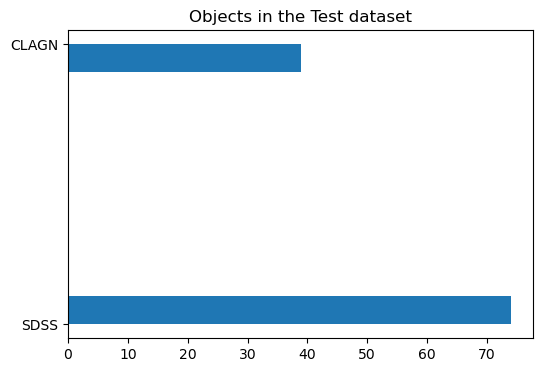

In [28]:
#plot to show how many of each type of object in the test dataset

plt.figure(figsize=(6,4))
plt.title("Objects in the Test dataset")
h = plt.hist(test_df.droplevel('datetime').index.unique().get_level_values('label').to_series(),histtype='stepfilled',orientation='horizontal')


### 3.2 Convert df_lc into X and y

In [29]:
#divide the dataframe into X and y for ML algorithms 

#X is the multiindex light curve without the labels
X_train  = train_df.droplevel('label')
X_test = test_df.droplevel('label')

#y are the labels, should be a series 
y_train = train_df.droplevel('datetime').index.unique().get_level_values('label').to_series()
y_test = test_df.droplevel('datetime').index.unique().get_level_values('label').to_series()



### 3.3 Check that the data types are ok for sktime

In [30]:
#ask sktime if it likes the data type of X
from sktime.datatypes import check_is_mtype

check_is_mtype(X_train, mtype="pd-multiindex", scitype="Panel", return_metadata=True)
#check_is_mtype(X_test, mtype="pd-multiindex", scitype="Panel", return_metadata=True)

(True,
 None,
 {'is_univariate': False,
  'is_empty': False,
  'has_nans': False,
  'n_instances': 338,
  'is_one_series': False,
  'is_equal_length': True,
  'is_equally_spaced': True,
  'n_panels': 1,
  'is_one_panel': True,
  'mtype': 'pd-multiindex',
  'scitype': 'Panel'})

## 4. Run Machine Learning Algorithms on the light curves

We choose to use [sktime](https://www.sktime.net/en/stable/index.html) algorithms beacuse it is a library of many algorithms specifically tailored to time series datasets.  It is based on the sklearn library so syntax is familiar to many users.

Types of classifiers are listed [here](https://www.sktime.net/en/stable/api_reference/classification.html).

This notebook will invert the actual workflow and show you a single example of the algorithm which best fits the data and has the most accurate classifier. Then it will show how to write a for loop over a bunch of classifiers before narrowing it down to the most accurate.



In [31]:
#what is the list of all possible classifiers that work with multivariate data
#all_tags(estimator_types = 'classifier')
classifiers = all_estimators("classifier", filter_tags={'capability:multivariate':True})
classifiers


[('Arsenal', sktime.classification.kernel_based._arsenal.Arsenal),
 ('BaggingClassifier',
  sktime.classification.ensemble._bagging.BaggingClassifier),
 ('CNNClassifier', sktime.classification.deep_learning.cnn.CNNClassifier),
 ('CanonicalIntervalForest',
  sktime.classification.interval_based._cif.CanonicalIntervalForest),
 ('Catch22Classifier',
  sktime.classification.feature_based._catch22_classifier.Catch22Classifier),
 ('ColumnEnsembleClassifier',
  sktime.classification.compose._column_ensemble.ColumnEnsembleClassifier),
 ('DrCIF', sktime.classification.interval_based._drcif.DrCIF),
 ('DummyClassifier', sktime.classification.dummy._dummy.DummyClassifier),
 ('FCNClassifier', sktime.classification.deep_learning.fcn.FCNClassifier),
 ('FreshPRINCE',
  sktime.classification.feature_based._fresh_prince.FreshPRINCE),
 ('HIVECOTEV2', sktime.classification.hybrid._hivecote_v2.HIVECOTEV2),
 ('InceptionTimeClassifier',
  sktime.classification.deep_learning.inceptiontime.InceptionTimeClassif

Accuracy of Random Interval Classifier: 0.8584070796460177



### 4.1 The Most Accurate Classifier
See section 4.2 for how we landed with this algorithm


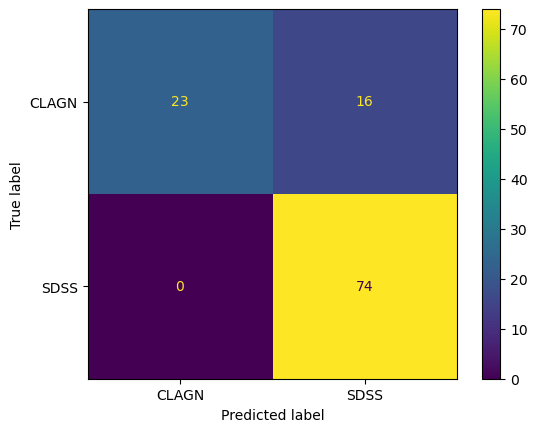

In [32]:
#looks like RandomIntervalClassifier is performing the best for the CLAGN (not for the SDSS)

#setup the classifier
clf = RandomIntervalClassifier(n_intervals = 20, n_jobs = -1, random_state = 43)

#fit the classifier on the training dataset
clf.fit(X_train, y_train)

#make predictions on the test dataset using the trained model 
y_pred = clf.predict(X_test)

print(f"Accuracy of Random Interval Classifier: {accuracy_score(y_test, y_pred)}\n", flush=True)

#plot a confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
    
plt.show()

### 4.2 Loop over a bunch of classifiers

Our method is to do a cursory check of a bunch of classifiers and then later drill down deeper on anything with good initial results.  We choose to run a loop over ~10 classifiers that seem promising and check the accuracy scores for each one.  Any classifier with a promising accuracy score could then be followed up with detailed hyperparameter tuning, or potentially with considering other classifiers in that same type.

In [ ]:
#which classifiers are we interestd in
#roughly one from each type of classifier

names = ["Arsenal",                     #kernel based
        "RocektClassifier",             #kernel based
        "CanonicalIntervalForest",      #interval based
        "HIVECOTEV2",                   #hybrid
#        "CNNClassifier",               #Deep Learning  - **requires tensorflow which is giving import errors
#        "WeightedEnsembleClassifier",   #Ensemble - **maybe use in the future if we find good options
        "IndividualTDE",               #Dictionary-based
        "KNeighborsTimeSeriesClassifier", #Distance Based
        "RandomIntervalClassifier",     #Feature based
        "Catch22Classifier",            #Feature based
        "ShapeletTransformClassifier"   #Shapelet based
        "DummyClassifier"]             #Dummy - ignores input

#for those with an impossible time limit, how long to let them run for before cutting off
nmins = 10

#these could certainly be more tailored
classifier_call = [Arsenal(time_limit_in_minutes=nmins, n_jobs = -1), 
                  RocketClassifier(num_kernels=2000),
                  CanonicalIntervalForest(n_jobs = -1),
                  HIVECOTEV2(time_limit_in_minutes=nmins, n_jobs = -1),
#                  CNNClassifier(),
#                  WeightedEnsembleClassifier(),
                  IndividualTDE(n_jobs=-1),
                  KNeighborsTimeSeriesClassifier(n_jobs = -1),
                  RandomIntervalClassifier(n_intervals = 20, n_jobs = -1, random_state = 43),
                  Catch22Classifier(outlier_norm = True, n_jobs = -1, random_state = 43),
                  ShapeletTransformClassifier(time_limit_in_minutes=nmins,n_jobs = -1),
                  DummyClassifier()]

#setup to store the accuracy scores
accscore_dict = {}

# iterate over classifiers
for name, clf in tqdm(zip(names, classifier_call)):
    #fit the classifier
    clf.fit(X_train, y_train)
    
    #make predictions on the test dataset
    y_pred = clf.predict(X_test)

    #calculate and track accuracy score
    accscore = accuracy_score(y_test, y_pred)
    print(f"Accuracy of {name} classifier: {accscore}\n", flush=True)
    accscore_dict[name] = accscore
    
    #plot confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
    disp.plot()
    plt.show()

#just for keeping track, I also tried 
#clf = SignatureClassifier(depth = 2, window_depth = 3, random_state = 43)
#this fails to complete, and is a known limitation of this algorithm.  

In [ ]:
#show the summary of the algorithms used and their accuracy score
accscore_dict

## 5.0 Conclusions:  
This classifier can be used to predict CLAGN.  The feature based algorithms do the best jobs of having little to no predicted CLAGN that are truly normal SDSS quasars.  We infer then that if the trained model predicts CLAGN, it is a very good target for follow-up spectroscopy to confirm CLAGN.  However this algorthim will not catch all CLAGN, and will incorrectly labels some CLAGN as being normal SDSS quasars.  THis algorithm can therefore not be used to find a complete sample of CLAGN, but can be used to increase the known sample.


### 5.1 Potential Areas of improvement
- Data is messy
    - ZTF calibration??
- Label inaccuracy is a concern
    - mostly SDSS, 
    - but CLAGN papers all have different selection criteria
- Not enough data on CLAGN
    - limited number of lightcurves
    - consider data augmentation